# データの整形
### 欠損値の補完

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
#データの読み込み
data = pd.read_csv("./../resources/house_prices/housing.csv")
#カテゴリカル変数に対して、one-hot-encodingを行う
data= pd.get_dummies(data,columns=['ocean_proximity'],dtype='int')
#特徴量とターゲットを分ける
normal_data = data[data['total_bedrooms'].notnull()] #欠損値がないデータ
missing_data = data[data['total_bedrooms'].isnull()] #欠損値があるデータ
#特徴量とターゲットを定義
x_normal = normal_data.drop(columns=['total_bedrooms'])
y_normal = normal_data['total_bedrooms']
x_missing = missing_data.drop(columns=['total_bedrooms'])
#ランダムフォレストモデルを訓練
rf = RandomForestRegressor(random_state=42)
rf.fit(x_normal,y_normal)
#欠損値を予測
missing_values_pre = rf.predict(x_missing)
#欠損値を補完
data.loc[data['total_bedrooms'].isnull(),'total_bedrooms'] = missing_values_pre

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#標準化する列
numeric_columns=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value']
#標準化
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
#目的変数を最後の列に移動する
target_column = "median_house_value"
target_data = data.pop(target_column)
data.insert(len(data.columns),target_column,target_data)
#訓練用データとテスト用データに分割
train_data,test_data = train_test_split(data,test_size=0.2,random_state=42)
#データの保存
data.to_csv('./../resources/house_prices/standardization_housing.csv',index=False)
train_data.to_csv('./../resources/house_prices/train_housing.csv',index=False)
test_data.to_csv('./../resources/house_prices/test_housing.csv',index=False)
print('データを保存しました。')


データを保存しました。


### 混合ガウスモデル（GMM）を使ったデータ拡張

In [2]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture

def train_gmm(numeric_feature,target_data,n_components_num=3,n_components_target=2):
    """
    GMMを学習し、特徴量と目的変数の分布をモデル化する関数
    """
    gmm_num = GaussianMixture(n_components=n_components_num,random_state=42)
    gmm_num.fit(numeric_feature)

    gmm_target = GaussianMixture(n_components=n_components_target,random_state=42)
    gmm_target.fit(target_data.reshape(-1,1))

    return gmm_num, gmm_target

def generate_data_gmm(gmm_num,gmm_target,num_col_list,cat_col_list,income_threshold,num_samples):
    """
    GMMを用いて新しいデータを生成し、median_income > income_thresholdの条件を満たすデータを保存する関数
    また、カテゴリ変数はランダムに1つだけ1にする。
    """
    generate_feature_num=[]
    generate_target=[]
    while len(generate_feature_num)<num_samples:
        feature_num_gmm = gmm_num.sample(num_samples*2)[0]
        target_gmm = gmm_target.sample(num_samples*2)[0].flatten()
        mask= feature_num_gmm[:,num_col_list.index("median_income")]>income_threshold
        feature_num_gmm_filtered = feature_num_gmm[mask]
        target_gmm_filtered=target_gmm[mask]
        for x,y in zip(feature_num_gmm_filtered,target_gmm_filtered):
            if len(generate_feature_num)<num_samples:
                generate_feature_num.append(x)
                generate_target.append(y)
            else:
                break
    #カテゴリ変数はランダムに1だけエンコードを選択
    feature_cat_gmm = np.zeros((num_samples,len(cat_col_list)))
    random_idx = np.random.randint(0,len(cat_col_list),num_samples)
    feature_cat_gmm[np.arange(num_samples),random_idx]=1

    return generate_feature_num, generate_target, feature_cat_gmm



data_path="./../resources/house_prices/train_housing.csv"
data = pd.read_csv(data_path)
target = "median_house_value"
features = data.drop(columns=[target])
#数値型特徴量とカテゴリ変数のリスト作成
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['int64']).columns
num_col_list=list(numeric_columns)
cat_col_list=list(categorical_columns)
#GMMの学習に使用するデータの取得
gmm_threshold=0
data_high_income = data[data["median_income"]>gmm_threshold]
feature_high = data_high_income[numeric_columns].values #数値特徴量
target_high = data_high_income[target].values #目的変数

income_threshold1=2.0#生成するデータの条件
num_samples = 2500 #生成する新規データ数
#GMMの学習
gmm_num_1,gmm_target_1 = train_gmm(feature_high,target_high)
#データの生成
generate_feature_num_1, generate_target_1, feature_cat_gmm_1=generate_data_gmm(gmm_num_1,gmm_target_1,num_col_list,cat_col_list,income_threshold1,num_samples)
#生成したデータをデータフレームに変換
df1_gmm_num = pd.DataFrame(generate_feature_num_1,columns=num_col_list)
df1_gmm_cat = pd.DataFrame(feature_cat_gmm_1,columns=cat_col_list)
df1_gmm = pd.concat([df1_gmm_num,df1_gmm_cat],axis=1)
df1_gmm[target] =generate_target_1



#GMMの学習に使用するデータの取得
gmm_threshold=3
data_high_income = data[data["median_income"]>gmm_threshold]
feature_high = data_high_income[numeric_columns].values
target_high = data_high_income[target].values

income_threshold2=4.0 #生成するデータの条件
num_samples = 500 #生成する新規データ数
#GMMの学習
gmm_num_2,gmm_target_2 = train_gmm(feature_high,target_high)
#データの生成
generate_feature_num_2, generate_target_2, feature_cat_gmm_2=generate_data_gmm(gmm_num_2,gmm_target_2,num_col_list,cat_col_list,income_threshold2,num_samples)
#生成したデータをデータフレームに変換
df2_gmm_num = pd.DataFrame(generate_feature_num_2,columns=num_col_list)
df2_gmm_cat = pd.DataFrame(feature_cat_gmm_2,columns=cat_col_list)
df2_gmm = pd.concat([df2_gmm_num,df2_gmm_cat],axis=1)
df2_gmm[target] =generate_target_2
#生成した2つのデータフレームを結合する
df_gmm = pd.concat([df1_gmm,df2_gmm])
#元のデータと生成したデータの結合
df_aug_gmm = pd.concat([data,df_gmm])
df_aug_gmm.to_csv("./../resources/house_prices/gmm_train_housing.csv",index=False)
print("データを保存しました。")

データを保存しました。


## データセットの確認

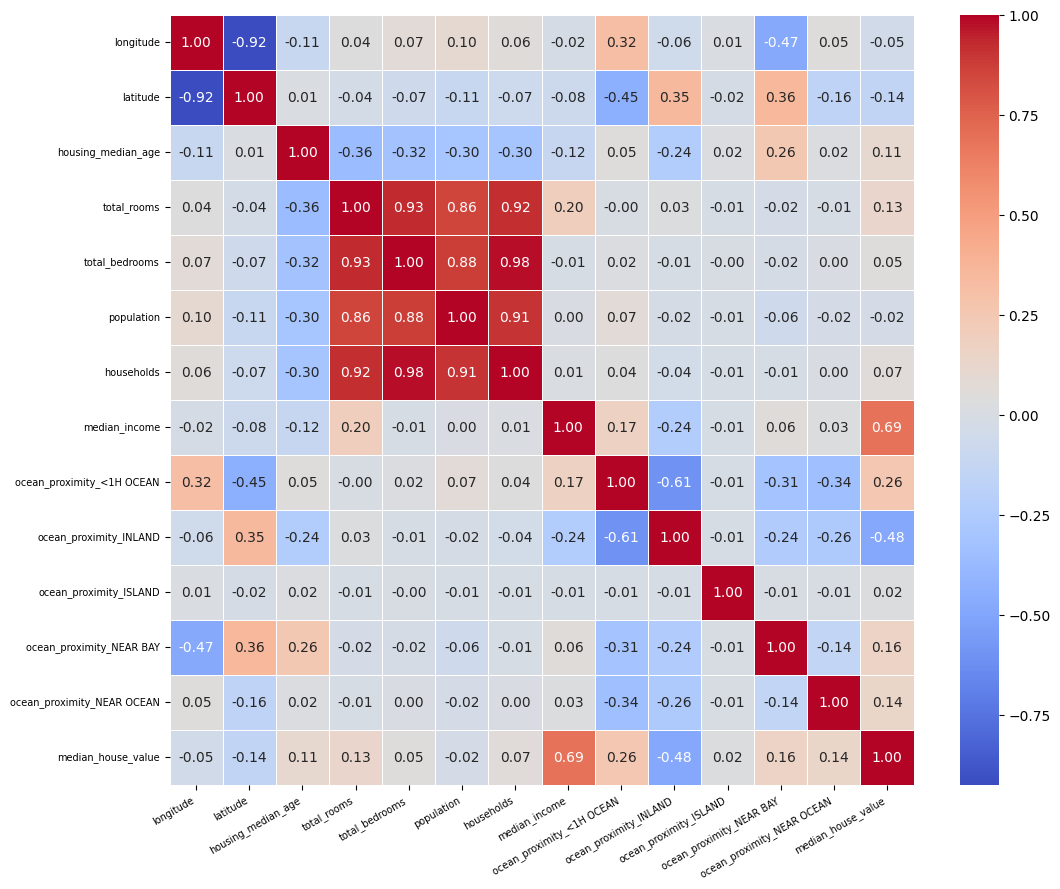

In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./../resources/house_prices/standardization_housing.csv')
correlation_matrix=data.corr()
plt.figure(figsize=(12,10))
ax=sns.heatmap(correlation_matrix,annot=True,cmap="coolwarm",fmt=".2f",linewidths=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha="right",fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=7)
plt.show()